#About the Dataset

link https://www.kaggle.com/datasets/varishabatool/data-set

context

This dataset contains medical insurance cost information for 1338 individuals. It includes demographic and health-related variables such as age, sex, BMI, number of children, smoking status, and residential region in the US. The target variable is charges, which represents the medical insurance cost billed to the individual.
This data set might have some missing values.

##Imports

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

##Load the data

In [2]:
df = pd.read_csv("insurance.csv")

##Explore the data

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.duplicated().sum()

np.int64(1)

In [5]:
df.isnull().sum().sum()

np.int64(0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
def uq(data,columns=[]):
  for col in columns:
    print(f"Unique values for column '{col}':")
    print(data[col].unique())
    print(f"\nValue counts for column '{col}':")
    print(data[col].value_counts())
    print("-" * 30)

In [8]:
uq(df,columns=["region","smoker","sex"])

Unique values for column 'region':
['southwest' 'southeast' 'northwest' 'northeast']

Value counts for column 'region':
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64
------------------------------
Unique values for column 'smoker':
['yes' 'no']

Value counts for column 'smoker':
smoker
no     1064
yes     274
Name: count, dtype: int64
------------------------------
Unique values for column 'sex':
['female' 'male']

Value counts for column 'sex':
sex
male      676
female    662
Name: count, dtype: int64
------------------------------


##Preprocessing

In [9]:
def one_hot_encode_object_columns(dataframe):
    """
    One-hot encodes object data type columns in a pandas DataFrame.

    Args:
        dataframe: The input pandas DataFrame.

    Returns:
        A new DataFrame with object columns one-hot encoded.
    """
    object_columns = dataframe.select_dtypes(include='object').columns
    encoded_df = pd.get_dummies(dataframe, columns=object_columns, drop_first=True)
    return encoded_df

# Apply the one-hot encoding function to the DataFrame
df = one_hot_encode_object_columns(df)
display(df.head())

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [10]:
# Convert boolean columns to integers
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

display(df.head())

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   sex_male          1338 non-null   int64  
 5   smoker_yes        1338 non-null   int64  
 6   region_northwest  1338 non-null   int64  
 7   region_southeast  1338 non-null   int64  
 8   region_southwest  1338 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 94.2 KB


##Training and Building the model

In [12]:
X = df.drop(columns=["charges"])
y = df["charges"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42
)


In [15]:
y_tr_log  = np.log1p(y_tr)
y_val_log = np.log1p(y_val)

In [19]:
model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,

)
model.fit(
    X_tr, y_tr_log,
    eval_set=[(X_val, y_val_log)],
)

[0]	validation_0-rmse:0.93841
[1]	validation_0-rmse:0.92983
[2]	validation_0-rmse:0.92035
[3]	validation_0-rmse:0.90583
[4]	validation_0-rmse:0.89694
[5]	validation_0-rmse:0.88230
[6]	validation_0-rmse:0.87345
[7]	validation_0-rmse:0.86088
[8]	validation_0-rmse:0.84802
[9]	validation_0-rmse:0.84215
[10]	validation_0-rmse:0.82993
[11]	validation_0-rmse:0.82849
[12]	validation_0-rmse:0.81648
[13]	validation_0-rmse:0.80985
[14]	validation_0-rmse:0.79790
[15]	validation_0-rmse:0.78627
[16]	validation_0-rmse:0.78254
[17]	validation_0-rmse:0.77776
[18]	validation_0-rmse:0.76651
[19]	validation_0-rmse:0.75549
[20]	validation_0-rmse:0.74487
[21]	validation_0-rmse:0.74245
[22]	validation_0-rmse:0.73192
[23]	validation_0-rmse:0.72215
[24]	validation_0-rmse:0.71222
[25]	validation_0-rmse:0.70987
[26]	validation_0-rmse:0.70047
[27]	validation_0-rmse:0.69703
[28]	validation_0-rmse:0.68819
[29]	validation_0-rmse:0.68310
[30]	validation_0-rmse:0.67989
[31]	validation_0-rmse:0.67115
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=-1, num_parallel_tree=None, ...)

📊 Model Performance
--------------------
RMSE : 5,357.45
MAE  : 2,794.20
R²   : 0.8151


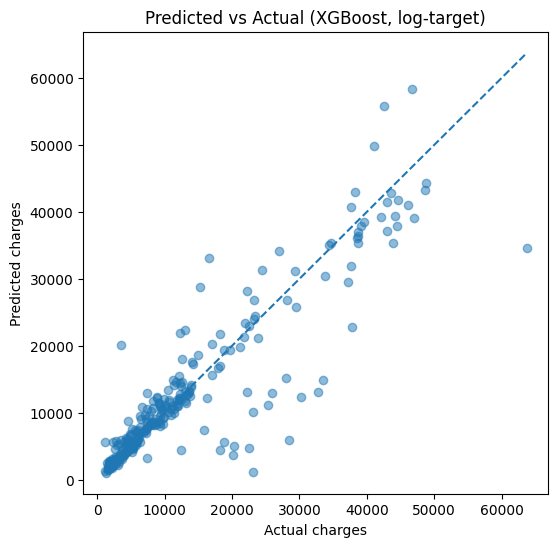

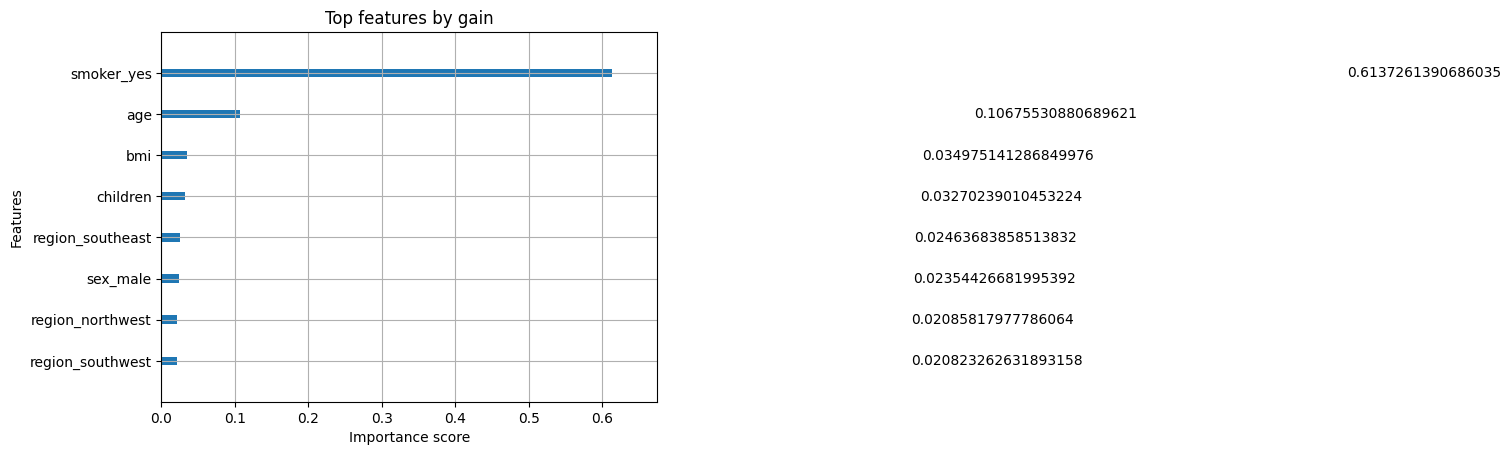

In [23]:
y_pred_log = model.predict(X_test)

# 8) Clamp insane predictions BEFORE expm1 to avoid overflow
#    Use training log-target range (with a small buffer) as guardrails
lo = np.percentile(y_tr_log, 0.5) - 0.5
hi = np.percentile(y_tr_log, 99.5) + 0.5
y_pred_log = np.clip(y_pred_log, lo, hi)

# (Extra safety) replace any non-finite with median log target
median_log = float(np.median(y_tr_log))
y_pred_log = np.where(np.isfinite(y_pred_log), y_pred_log, median_log)

# 9) Back-transform to original scale
y_pred = np.expm1(y_pred_log)

# 10) Metrics
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae  = float(mean_absolute_error(y_test, y_pred))
r2   = float(r2_score(y_test, y_pred))

print("📊 Model Performance")
print("--------------------")
print(f"RMSE : {rmse:,.2f}")
print(f"MAE  : {mae:,.2f}")
print(f"R²   : {r2:.4f}")

# 11) Quick diagnostic: predicted-vs-actual plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], '--')
plt.xlabel("Actual charges")
plt.ylabel("Predicted charges")
plt.title("Predicted vs Actual (XGBoost, log-target)")
plt.show()

# 12) (Optional) see what matters most
xgb.plot_importance(model, importance_type="gain", max_num_features=15)
plt.title("Top features by gain")
plt.show()